In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import copy
from tqdm import tqdm

In [2]:
#================================================
# Load Data
#=================================================
raw_data_1 = pd.read_csv('./train_trendency.csv', index_col=['Province_State'])
raw_data_1 = raw_data_1.drop('Unnamed: 0', axis=1)
print(raw_data_1.columns)
#cleaned_df = raw_data_1.dropna(axis=1)
#raw_data_1 = raw_data_1.fillna(0)
#print(cleaned_df.columns)    
state_population = pd.read_csv('./State Populations.csv', index_col='State')

#raw_data_2 = pd.read_csv('./train_vaccine.csv', index_col=['location', 'date'])
#raw_data_2 = raw_data_2.drop('Unnamed: 0', axis=1)
#print(raw_data_2)
#cleaned_df_2 = raw_data_2.dropna(axis=1)
#print(cleaned_df_2.columns)

Index(['Date', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Incident_Rate',
       'Total_Test_Results', 'Case_Fatality_Ratio', 'Testing_Rate'],
      dtype='object')


In [3]:
vaccine_data = pd.read_csv('train_vaccine.csv', index_col=['location'])
vaccine_data['date'] = pd.to_datetime(vaccine_data['date'], format='%Y-%m-%d')
vaccine_data['date'] = vaccine_data['date'].apply(lambda x: x.strftime('%m-%d-%Y'))
vaccine_data = vaccine_data.set_index('date', append=True)
#print(vaccine_data)
vaccine_data = vaccine_data.drop('Unnamed: 0', axis=1)
vaccine_data.rename(columns={'location':'Province_State', 'date':'Date'})
#print(vaccine_data)
#print(raw_data_1.shape)
raw_data_1 = raw_data_1.join(vaccine_data, on=['Province_State', 'Date'])
#print(raw_data_1['people_fully_vaccinated'].isna().sum())


In [4]:
# Now I want to know which states have full recovered and active, which have some, and which have none
state_full = []
state_partial = []
state_none = []
States = list(set(raw_data_1.index.get_level_values('Province_State').values))
for state in States:
    # if we have recovered, then confirmed - death - recovered = active
    # in some cases, we have active, confirmed, death but no recovered,
    # I think in this situation, active may not be real active
    recovered = raw_data_1.loc[state, 'Recovered']
    if recovered.isna().all():
        state_none.append(state)
    elif recovered.isna().any():
        state_partial.append((state, recovered.isna().sum(), recovered.isna()))
    else:
        state_full.append(state)

threshold = 50
true_state_partial = []
for state, number, mask in state_partial:
    if number > 37:
        state_none.append(state)
    else:
        true_state_partial.append((state, number))

print(state_full)
for state, number in true_state_partial:
    print(state, number)
print(state_none)

#raw_data_1['Recovered'] = raw_data_1['Confirmed'] - raw_data_1['Deaths'] - raw_data_1['Active']


[]
Kansas 37
Michigan 25
Mississippi 25
Texas 25
Rhode Island 37
Arkansas 25
Ohio 25
Iowa 25
New Hampshire 25
New Mexico 25
South Carolina 25
Tennessee 25
Indiana 37
Massachusetts 25
Utah 25
Wisconsin 25
West Virginia 25
Montana 25
South Dakota 25
Kentucky 25
Oklahoma 25
Nebraska 25
Minnesota 25
New Jersey 37
Idaho 25
Wyoming 25
Colorado 37
Pennsylvania 25
Louisiana 25
Maine 25
New York 37
Arizona 37
Alabama 25
North Carolina 37
Virginia 37
Vermont 25
Maryland 25
North Dakota 25
['Washington', 'Missouri', 'Georgia', 'Florida', 'California', 'Illinois', 'Nevada', 'Oregon', 'Hawaii', 'Alaska', 'Connecticut', 'Delaware']


In [5]:
# First do some data cleaning, make "Deaths", "Confirmed", "Active" monotonically increase
data = raw_data_1.copy(deep=True)
for state in States:
    for col in ['Deaths', 'Confirmed', 'Recovered', 'people_fully_vaccinated']:
        values = data.loc[state, col].values
        length = values.shape[0]
        last_non_nan_value = values[0]
        for i in range(1, length):
            if not np.isnan(values[i]):
                if values[i] < last_non_nan_value:
                    values[i] = last_non_nan_value
                last_non_nan_value = values[i]
        data.loc[data.index==state,col] = values
data['Active'] = data['Confirmed'] - data['Deaths'] - data['Recovered']
    

data['Increased Deaths'] = 0
data['Increased Confirmed'] = 0
data['Increased Recovered'] = 0
for state in States:
    inc_deaths = data.loc[state, 'Deaths'].values[1:] - data.loc[state, 'Deaths'].values[:-1]
    inc_deaths = np.concatenate([[data.loc[state, 'Deaths'].values[0]], inc_deaths])
    data.loc[data.index==state, 'Increased Deaths'] = inc_deaths
    
    inc_confirmed = data.loc[state, 'Confirmed'].values[1:] - data.loc[state, 'Confirmed'].values[:-1]
    inc_confirmed = np.concatenate([[data.loc[state, 'Confirmed'].values[0]], inc_confirmed])
    data.loc[data.index==state, 'Increased Confirmed'] = inc_confirmed
    
    inc_recovered = data.loc[state, 'Recovered'].values[1:] - data.loc[state, 'Recovered'].values[:-1]
    inc_recovered = np.concatenate([[data.loc[state, 'Recovered'].values[0]], inc_recovered])
    data.loc[data.index==state, 'Increased Recovered'] = inc_recovered
 
print('finished inserting new columns')


    
    

finished inserting new columns


In [6]:
# Process States with weekly updated recovered data
target_states = ['Mississippi', 'Michigan', 'Alabama', 'Louisiana', 'Massachusetts', 'North Carolina']
for state in target_states:
    #print(data.loc[state, 'Recovered'])
    inc = data.loc[state, 'Increased Recovered'].values
    i = 0
    j = 0
    while not np.isnan(inc[i]):
        if inc[i] != 0:
            if i == j:
                i += 1
                j += 1
                continue
            else:
                cnt = i - j + 1
                ave_inc = inc[i]/cnt
                for k in range(j,i+1):
                    inc[k] = ave_inc
                j = i + 1
                i += 1
                continue
        else:
            # inc[i] == 0
            i += 1
    data.loc[data.index==state, 'Increased Recovered'] = inc
    cum = np.cumsum(inc)
    data.loc[data.index==state, 'Recovered'] = cum
            

In [7]:
# Since all the states have partial data, I want to use methods in "Epidemic Model Guided Machine Learning for
# COVID-19 Forecasts in the United States" to estimate Recovered based on Deaths
# It assumes that increased death / (increased recoverd + 1)= r(t) = a*exp(-bt) (This may not be a good way)


class RatioByDate(nn.Module):
    def __init__(self):
        super(RatioByDate, self).__init__()
        self.linear = nn.Linear(1,1)
        torch.nn.init.uniform_(self.linear.weight,-1, 0)
        
    def forward(self, x):
        #return self.linear(x)
        return torch.exp(self.linear(x))

class RatioByDatePoly(nn.Module):
    def __init__(self, order = 3):
        super(RatioByDatePoly, self).__init__()
        self.order = order
        self.linear = nn.Linear(order+1,1, bias=False)
#        torch.nn.init.uniform_(self.linear.weight,-1, 0)
        
    def forward(self, x):
        x = x/100
        return self.linear(torch.cat([x**i for i in range(self.order+1)], dim=-1))
        
    
def train(model, x, y, min_ratio):
    criterion = nn.L1Loss()
    epochs = 10000
    lr = 1e-3
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        model.train()
        pred = model(x)
        loss = criterion(pred, y)
        reg_loss = torch.mean(torch.abs(model.linear.weight))
        loss += 0.1 * reg_loss
        loss.backward()
        optimizer.step()
        #with torch.no_grad():
        #    model.linear.weight.copy_(torch.clamp(model.linear.weight, max = 0, min = math.log(min_ratio)/80))
   # print(reg_loss)
    
# estimate a, b for states having enough recoverd, death data
state_ratio_by_date = {}
plot_cnt = 4
plot_cur = 0

"""
for state, _ in tqdm(true_state_partial):
    inc_deaths = data.loc[state, 'Increased Deaths'].values
    inc_recovered = data.loc[state, 'Increased Recovered'].values
    ratio = inc_deaths[1:] / (inc_recovered[1:] + inc_deaths[1:] + 1)
    date = np.array(list(range(1, inc_deaths.shape[0])))
    
    model = RatioByDatePoly()
    mask = ((1 - np.isnan(ratio)) * (ratio != 0)).astype(np.bool_)
    
    x = torch.FloatTensor(date[mask]).view(-1,1)
    y = torch.FloatTensor(ratio[mask]).view(-1,1)
    min_ratio = torch.min(y).item()/5
    train(model, x, y, min_ratio)
    
    #a, b = model.linear.weight[0,0].detach().item(), model.linear.bias[0].detach().item()
    state_ratio_by_date[state] = model
 
    pred_recovered = [inc_recovered[0]]
    for t in date:
        inc_death = inc_deaths[t]
        #ratio = np.exp(a*t+b)
        ratio = model(torch.FloatTensor([t])).item()
        pred_inc_recovered = inc_death / ratio - 1 - inc_death
        if np.isnan(inc_recovered[t]) == False:
            recovered_t = pred_recovered[-1] + inc_recovered[t]
        else:
            recovered_t = pred_recovered[-1] + pred_inc_recovered
        pred_recovered.append(recovered_t)
    data['Recovered'].loc[state] = np.round(np.array(pred_recovered)).astype(np.int)
    #print(data['Recovered'].loc[state])
    mask = np.array([False]+list(mask))
    error = np.abs(np.array(pred_recovered)[mask] - data.loc[state, 'Recovered'].values[mask])
    error = error / data.loc[state, 'Recovered'].values[mask]
    #print(state)
    #print(np.mean(error))
    if False:
        #pass
        #print(state)
        #print(inc_deaths)
        #print(inc_recovered)
        #print(data.loc[state, 'Deaths'])
        #print(ratio)
        #print(y.squeeze())
        #pred = model(x).squeeze()
        #print(pred)
        #print(model.linear.weight)
        #print(a, b)
        date = np.array(list(range(0, inc_deaths.shape[0])))
        plt.figure()
        #plt.plot(x,y,c='blue')
        #plt.plot(x,pred.detach(),c='red')
        plt.plot(date, data.loc[state, 'Recovered'].values, c='blue')
        plt.plot(date, np.array(pred_recovered), c='green')
        plt.show()
        plot_cur += 1
            
data['Active'] = data['Confirmed'] - data['Deaths'] - data['Recovered']
print('Finish')
"""


for state, _ in tqdm(true_state_partial):
    deaths = data.loc[state, 'Deaths'].values
    recovered = data.loc[state, 'Recovered'].values
    ratios = deaths / (deaths + recovered + 1)
    date = np.array(range(deaths.shape[0]))
    
    model = RatioByDatePoly(order = 1)
    mask = ((1 - np.isnan(ratios)) * (ratios != 0)).astype(np.bool_)
    
    x = torch.FloatTensor(date[mask]).view(-1,1)
    y = torch.FloatTensor(ratios[mask]).view(-1,1)
    min_ratio = torch.min(y).item()/5
    train(model, x, y, min_ratio)
    
    #a, b = model.linear.weight[0,0].detach().item(), model.linear.bias[0].detach().item()
    state_ratio_by_date[state] = model
 
    pred_recovered = np.zeros_like(recovered)
    for t in date:
        ratio = model(torch.FloatTensor([t])).item()
        pred = (deaths[t] / ratio) - 1 - deaths[t]
        if np.isnan(recovered[t]):
            pred_recovered[t] = pred
        else:
            pred_recovered[t] = recovered[t]
    
    mask = np.array(list(mask))
    error = np.abs(np.array(pred_recovered)[mask] - data.loc[state, 'Recovered'].values[mask])
    error = error / data.loc[state, 'Recovered'].values[mask]
    data.loc[data.index==state, 'Recovered'] = pred_recovered
    #print(np.mean(error))
    if False:
        date = np.array(list(range(0, inc_deaths.shape[0])))
        plt.figure()
        plt.plot(date, data.loc[state, 'Recovered'].values, c='blue')
        plt.plot(date, np.array(pred_recovered), c='green')
        plt.show()
        plot_cur += 1
            
data['Active'] = data['Confirmed'] - data['Deaths'] - data['Recovered']

# set entries where active < 0 to 0, and recmopute recovered 
data.loc[data['Active']<0, 'Active'] = 0
data['Recovered'] = data['Confirmed'] - data['Deaths'] - data['Active']
print('Finish')

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [02:33<00:00,  3.99s/it]


Finish


In [8]:
def SuEIR(t, y, N, beta, sigma, mu, gamma):
    # y[0] is S, y[1] is E, y[2] is I, y[3] is R
    gradient = np.zeros_like(y)
    gradient[0] = - beta * (y[2] + y[1]) * y[0] / N
    gradient[1] = beta * (y[2] + y[1]) * y[0] / N - sigma * y[1]
    gradient[2] =  mu * sigma * y[1] - gamma * y[2]
    gradient[3] = gamma * y[2]
    return gradient

def predict_with_ODE(fun, t_span, y0, t_eval, args):
    sol = solve_ivp(lambda t,y: fun(t,y,*args), t_span, y0, t_eval = t_eval)
    return sol.y

def optimize_SuEIR_parameters(beta0, sigma0, mu0, gamma0, N0, I, R, t_span, y0, t_eval, deaths, ratios):
    I_max = np.max(I)
    R_max = np.max(R)
    scale_I = I / I_max
    scale_R = R / R_max
    scale_D = deaths / R_max
    #print(scale_I)
    #print(scale_R)
   
    def loss(x):
        y = predict_with_ODE(SuEIR, t_span, y0, t_eval, args = (N0, x[0], x[1], x[2], x[3]))
        #print(y)
        I_pred = y[2,:] / I_max
        R_pred = y[3,:] / R_max
        #D_pred = (R_pred + 1) * ratios
        
        Inc_R_pred = y[3, 1:] - y[3,:-1]
        Inc_D_pred = (Inc_R_pred + 1) * ratios[1:]
        D_pred = np.zeros_like(deaths)
        D_pred[0] = deaths[0]
        D_pred[1:] = Inc_D_pred
        D_pred = np.cumsum(D_pred)
        D_pred = D_pred / R_max
        res = np.array(np.concatenate([I_pred-scale_I, R_pred - scale_R, D_pred - scale_D])).astype(np.float64)
        return res
    x0 = np.array([beta0, sigma0, mu0, gamma0])
    return least_squares(loss, x0, bounds = (0, 1))

def optimize_SuEIR_parameters_2(beta0, sigma0, mu0, gamma0, N0, I, R, t_span, y0, t_eval, deaths, ratios):
    I_max = np.max(I)
    R_max = np.max(R)
    scale_I = I / I_max
    scale_R = R / R_max
    scale_D = deaths / R_max
    #print(scale_I)
    #print(scale_R)
   
    def loss(x):
        y = predict_with_ODE(SuEIR, t_span, y0, t_eval, args = (N0, x[0], x[1], x[2], x[3]))
        #print(y)
        I_pred = y[2,:] / I_max
        R_pred = y[3,:] / R_max
        D_pred = (R_pred + 1) * ratios
        #return np.mean((I_pred-scale_I)**2) + np.mean((R_pred-scale_R)**2) + np.mean((D_pred-scale_D)**2)
        res = np.array(np.concatenate([I_pred-scale_I, R_pred - scale_R, D_pred - scale_D])).astype(np.float64)
        #print(res)
        #print(np.isfinite(res))
        return res
    
    x0 = np.array([beta0, sigma0, mu0, gamma0])
    return least_squares(loss, x0, bounds = (0, 1))

In [9]:
N0_ratio_list = [0.7, 0.8, 0.9, 1]
E0_ratio_list = [0.1, 0.2, 0.3]


best_ratio = {}
state_params = {}
best_mape_list = []
for state, _ in tqdm(true_state_partial):
    best_mape = 10
    for N0_ratio in N0_ratio_list:
        for E0_ratio in E0_ratio_list:
            # split training and validation set
            values = data.loc[state].values
            training_data = values[:-7,:]
            valid_data = values[-7:,:]
    
            # set y0
            I0 = values[0,4] # Active
            R0 = values[0,2] + values[0,3] # Recovered + Death
            N0 = N0_ratio * state_population.loc[state].values[0]
            E0 = E0_ratio * state_population.loc[state].values[0]
            S0 = N0 - E0 - I0 - R0
            y0 = np.array([S0, E0, I0, R0])
    
            # set initial values for parameters
            x0 = np.random.rand(4)
    
            # set t_span, t_eval
            t_span = (0, training_data.shape[0]-1)
            t_eval = np.array(list(range(training_data.shape[0]))).astype(np.float64)
    
            # retrieve I, R
            I = training_data[:,4]
            R = training_data[:,2] + training_data[:,3]
            deaths = training_data[:,2]
            date = np.array(range(values.shape[0])).astype(np.float64)
            ratios = state_ratio_by_date[state](torch.FloatTensor(date).view(-1,1))
            ratios = ratios.detach().numpy().squeeze()
            
    
            res = optimize_SuEIR_parameters_2(x0[0], x0[1], x0[2], x0[3], N0, I, R, t_span, y0, t_eval, deaths, ratios[:-7])
    
            # predict with learned parameters and compute MAPE on validation dataset
            pred = predict_with_ODE(SuEIR, (0, values.shape[0]), y0, t_eval = np.array(list(range(values.shape[0]))).astype(np.float64), 
                                   args = (N0, res.x[0], res.x[1], res.x[2], res.x[3]))
            pred_valid = pred[2,-7:] + pred[3,-7:]
            
            death_valid = valid_data[:,2]
            #pred_death = (pred[3,-7:] + 1) * ratios[-7:]
            
            pred_remove = pred[3,:]
            
            pred_death_ = (pred_remove + 1) * ratios
            """
            pred_inc_remove = pred_remove[1:] - pred_remove[:-1]
            pred_inc_death = (pred_inc_remove+1) * ratios[1:]
            pred_death_ = np.zeros_like(pred_remove)
            pred_death_[0] = deaths[0]
            pred_death_[1:] = pred_inc_death
            pred_death_ = np.cumsum(pred_death_)
            #print(pred_remove)
            #print(ratios)
            #print(pred_inc_death)
            """
            pred_death_ = pred_death_[-7:]
            
            mape = np.mean(np.abs(valid_data[:,1]-pred_valid) / valid_data[:,1]) +\
                            np.mean(np.abs(pred_death_-death_valid)/death_valid)
            
            #break
        #mape = np.mean(mape_cfm)
            if mape < best_mape:
                best_mape = mape
                best_ratio[state] = (N0_ratio, E0_ratio)
                state_params[state] = copy.deepcopy(res)
    best_mape_list.append(best_mape) 
    print(state, best_ratio[state], best_mape)
    #break
    #break
#N0_ratio, E0_ratio = best_ratio[0], best_ratio[1]
#print('Best ratio is N0 ratio: %.3f, E0 ratio: %.3f, validation mape: %.3f'%(N0_ratio, E0_ratio, np.mean(best_mape)) #0.117
print(np.mean(best_mape_list))

  0%|                                                                                           | 0/38 [00:00<?, ?it/s]

Kansas (0.8, 0.2) 0.1358465022371576


  3%|██▏                                                                                | 1/38 [00:04<02:47,  4.54s/it]

Michigan (0.9, 0.2) 0.037213138143075294


  5%|████▎                                                                              | 2/38 [00:19<04:31,  7.55s/it]

Mississippi (0.7, 0.3) 0.08245735077482388


  8%|██████▌                                                                            | 3/38 [00:22<03:44,  6.41s/it]

Texas (0.7, 0.3) 0.07475142023733145


 11%|████████▋                                                                          | 4/38 [00:25<03:00,  5.32s/it]

Rhode Island (0.9, 0.1) 0.04644155000029951


 13%|██████████▉                                                                        | 5/38 [00:30<02:51,  5.20s/it]

Arkansas (0.8, 0.1) 0.01720988411281419


 16%|█████████████                                                                      | 6/38 [00:34<02:35,  4.85s/it]

Ohio (1, 0.1) 0.0864461831020044


 18%|███████████████▎                                                                   | 7/38 [00:37<02:14,  4.34s/it]

Iowa (0.9, 0.1) 0.03981729279197244


 21%|█████████████████▍                                                                 | 8/38 [00:50<03:26,  6.87s/it]

New Hampshire (1, 0.3) 0.0681313111147086


 24%|███████████████████▋                                                               | 9/38 [00:55<02:59,  6.18s/it]

New Mexico (0.9, 0.2) 0.10413129388832017


 26%|█████████████████████▌                                                            | 10/38 [00:59<02:37,  5.64s/it]

South Carolina (0.9, 0.2) 0.09919716781377827


 29%|███████████████████████▋                                                          | 11/38 [01:10<03:15,  7.22s/it]

Tennessee (1, 0.1) 0.02685376327964945


 32%|█████████████████████████▉                                                        | 12/38 [01:17<03:04,  7.11s/it]

Indiana (1, 0.1) 0.06377732261573786


 34%|████████████████████████████                                                      | 13/38 [01:28<03:25,  8.22s/it]

Massachusetts (1, 0.3) 0.08855125780155684


 37%|██████████████████████████████▏                                                   | 14/38 [01:31<02:39,  6.65s/it]

Utah (0.7, 0.1) 0.0732733155495482


 39%|████████████████████████████████▎                                                 | 15/38 [01:35<02:15,  5.89s/it]

Wisconsin (0.7, 0.1) 0.09069868373525894


 42%|██████████████████████████████████▌                                               | 16/38 [01:44<02:33,  6.96s/it]

West Virginia (0.7, 0.3) 0.21439747025531125


 45%|████████████████████████████████████▋                                             | 17/38 [01:48<02:04,  5.93s/it]

Montana (0.8, 0.3) 0.03511062471164543


 47%|██████████████████████████████████████▊                                           | 18/38 [01:59<02:29,  7.48s/it]

South Dakota (1, 0.2) 0.01884927164280567


 50%|█████████████████████████████████████████                                         | 19/38 [02:29<04:33, 14.37s/it]

Kentucky (1, 0.2) 0.041626568665599224


 53%|███████████████████████████████████████████▏                                      | 20/38 [02:35<03:30, 11.69s/it]

Oklahoma (0.7, 0.3) 0.013298132288789262


 55%|█████████████████████████████████████████████▎                                    | 21/38 [02:38<02:36,  9.19s/it]

Nebraska (1, 0.2) 0.014234394641466207


 58%|███████████████████████████████████████████████▍                                  | 22/38 [02:45<02:14,  8.43s/it]

Minnesota (0.7, 0.1) 0.03554586447137163


 61%|█████████████████████████████████████████████████▋                                | 23/38 [02:50<01:50,  7.38s/it]

New Jersey (1, 0.1) 0.07494363134367966


 63%|███████████████████████████████████████████████████▊                              | 24/38 [02:55<01:36,  6.87s/it]

Idaho (1, 0.1) 0.039476069163743015


 66%|█████████████████████████████████████████████████████▉                            | 25/38 [03:24<02:54, 13.43s/it]

Wyoming (0.8, 0.3) 0.033968672603863846


 68%|████████████████████████████████████████████████████████                          | 26/38 [03:56<03:48, 19.02s/it]

Colorado (1, 0.1) 0.033221488766409554


 71%|██████████████████████████████████████████████████████████▎                       | 27/38 [04:02<02:45, 15.02s/it]

Pennsylvania (0.7, 0.3) 0.09104019200174238


 74%|████████████████████████████████████████████████████████████▍                     | 28/38 [04:06<01:58, 11.89s/it]

Louisiana (0.7, 0.3) 0.10008177673610097


 76%|██████████████████████████████████████████████████████████████▌                   | 29/38 [04:11<01:26,  9.64s/it]

Maine (1, 0.1) 0.10621790632385515


 79%|████████████████████████████████████████████████████████████████▋                 | 30/38 [04:17<01:07,  8.50s/it]

New York (1, 0.1) 0.0690295326124783


 82%|██████████████████████████████████████████████████████████████████▉               | 31/38 [04:23<00:54,  7.74s/it]

Arizona (0.7, 0.3) 0.10233053630214314


 84%|█████████████████████████████████████████████████████████████████████             | 32/38 [04:30<00:45,  7.52s/it]

Alabama (0.9, 0.1) 0.13610105545789836


 87%|███████████████████████████████████████████████████████████████████████▏          | 33/38 [04:48<00:54, 10.94s/it]

North Carolina (1, 0.3) 0.024904801033186652


 89%|█████████████████████████████████████████████████████████████████████████▎        | 34/38 [04:53<00:36,  9.12s/it]

Virginia (0.8, 0.1) 0.03194655379170254


 92%|███████████████████████████████████████████████████████████████████████████▌      | 35/38 [05:06<00:30, 10.21s/it]

Vermont (0.9, 0.1) 0.336448957920361


 95%|█████████████████████████████████████████████████████████████████████████████▋    | 36/38 [05:10<00:16,  8.33s/it]

Maryland (1, 0.1) 0.11104317868045928


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 37/38 [05:15<00:07,  7.39s/it]

North Dakota (0.7, 0.1) 0.06572793289869375


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [05:33<00:00, 10.60s/it]


0.07537742235556168


In [10]:
# predict
pred_cfm = {}
pred_death = {}
for state, _ in true_state_partial:
    # split training and validation set
    values = data.loc[state].values
    training_data = values[:,:]
#    valid_data = values[-7:,:]
    N0_ratio, E0_ratio = best_ratio[state]
    # set y0
    I0 = values[0,4] # Active
    R0 = values[0,2] + values[0,3] # Recovered + Death
    N0 = N0_ratio * state_population.loc[state].values[0]
    E0 = E0_ratio * state_population.loc[state].values[0]
    S0 = N0 - E0 - I0 - R0
    y0 = np.array([S0, E0, I0, R0])
    
    # set initial values for parameters
    #x0 = np.random.rand(4)
    
    # set t_span, t_eval
    t_span = (0, values.shape[0]+1)
    t_eval = np.array(range(values.shape[0])).astype(np.float64)
    res = state_params[state]
    pred = predict_with_ODE(SuEIR, t_span, y0, t_eval = t_eval, 
                           args = (N0, res.x[0], res.x[1], res.x[2], res.x[3]))
    
    new_S0, new_E0 = pred[0, values.shape[0]-1], pred[1, values.shape[0]-1]
    t_span = (0, 31)
    t_eval = np.array(range(31)).astype(np.float64)
    
    # retrieve I, R
    #I = training_data[:,4]
    #R = training_data[:,2] + training_data[:,3]
    
    #res = optimize_SuEIR_parameters(x0[0], x0[1], x0[2], x0[3], N0, I, R, t_span, y0, t_eval)
    #state_params[state] = res.x
    y0 = np.array([new_S0, new_E0, values[78,4], values[78,2]+values[78,3]])
    pred = predict_with_ODE(SuEIR, t_span, y0, t_eval = t_eval, 
                           args = (N0, res.x[0], res.x[1], res.x[2], res.x[3]))
    pred_cfm[state] = pred[2,1:31] + pred[3,1:31]
    
    date = np.array(range(values.shape[0]+30)).astype(np.float64)
    ratio = state_ratio_by_date[state](torch.FloatTensor(date).view(-1,1))
    ratio = ratio.detach().numpy().squeeze()
    
    death = (pred[3,1:31] + 1) * ratio[-30:]
    #print(death.shape)
    #break
    pred_death[state] = death
    """
    pred_remove = pred[3,:]
    pred_inc_remove = pred_remove[1:] - pred_remove[:-1]
    pred_inc_death = (pred_inc_remove+1) * ratio[1:]
    pred_death_ = np.zeros_like(pred_remove)
    pred_death_[0] = deaths[0]
    pred_death_[1:] = pred_inc_death
    pred_death_ = np.cumsum(pred_death_)
    pred_death[state] = pred_death_[-30:]
    """
print('Finish')

Finish


In [11]:
best_ratio_value = np.array(list(best_ratio.values()))
N0_E0_ratio = np.mean(best_ratio_value, axis=0)
#print(N0_E0_ratio)
N0_ratio, E0_ratio = N0_E0_ratio[0], N0_E0_ratio[1]
print(N0_ratio, E0_ratio)

0.868421052631579 0.18157894736842095


In [12]:
# Now process states without recovered number
a_list = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
b_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

def predictRatio(t, a, b):
    t = t/100
    return a * t + b

train_date = 72
valid_date = 79
total_date = 109

for state in tqdm(state_none):
    # Try to predict Recovered Data
    best_params = None
    best_mape = 100
    death = data.loc[state, 'Deaths'].values
    confirmed = data.loc[state, 'Confirmed'].values
    for a in a_list:
        for b in b_list:
            t = np.array(range(0, total_date)).astype(np.float64)
            ratio = predictRatio(t, a, b)
            if np.sum(ratio <= 0) > 0:
                continue
            #print(ratio)
            removed = death / ratio[:valid_date] - 1
            active =  confirmed - removed
            
            I0 = active[0]
            R0 = removed[0]
            N0 = N0_ratio * state_population.loc[state].values[0]
            E0 = E0_ratio * state_population.loc[state].values[0]
            S0 = N0 - E0 - I0 - R0
            y0 = np.array([S0, E0, I0, R0])
            #print(ratio)
            #print(y0)
            #print(N0)
            x0 = np.random.rand(4)
            
            t_span = (0, train_date)
            t_eval = np.array(range(0, train_date)).astype(np.float64)
            
            I = active[:train_date]
            R = removed[:train_date]
            
            #print(I)
            #print(R)
            
            res = optimize_SuEIR_parameters_2(x0[0], x0[1], x0[2], x0[3], N0, I, R, t_span, y0, t_eval, death[:train_date], ratio[:train_date])
            
            pred = predict_with_ODE(SuEIR, (0, valid_date), y0, t_eval = np.array(list(range(valid_date))).astype(np.float64), 
                           args = (N0, res.x[0], res.x[1], res.x[2], res.x[3]))
            pred_valid = pred[2,-7:] + pred[3,-7:]
            valid_data = data.loc[state, 'Confirmed'].values[-7:]
            
            pred_death_ = (pred[3,-7:] + 1) * ratio[-7:]
            valid_death = death[-7:]
            mape = np.mean(np.abs(valid_data-pred_valid) / valid_data) + np.mean(np.abs(valid_death-pred_death_)/valid_death)
            if mape < best_mape:
                best_mape = mape
                best_params = (a, b, N0, res.x[0], res.x[1], res.x[2], res.x[3])
    print(state, best_mape)
    ratio = predictRatio(0, best_params[0], best_params[1])
    R0 = death[0]/ratio - 1
    I0 = confirmed[0] - R0
    N0 = N0_ratio * state_population.loc[state].values[0]
    E0 = E0_ratio * state_population.loc[state].values[0]
    S0 = N0 - E0 - I0 - R0
    y0 = np.array([S0, E0, I0, R0])
    
    state_params[state] = best_params
    # use best parameters to predict
    pred = predict_with_ODE(SuEIR, (0, total_date), y0, t_eval = np.array(range(total_date)).astype(np.float64), 
                           args = best_params[-5:])
    
    new_S0, new_E0 = pred[0, valid_date-1], pred[1, valid_date-1]
    t_span = (0, total_date - valid_date)
    t_eval = np.array(range(31)).astype(np.float64)
    ratio = predictRatio(valid_date-1, best_params[0], best_params[1])
    new_R0 = death[valid_date-1]/ratio - 1
    
    # retrieve I, R
    #I = training_data[:,4]
    #R = training_data[:,2] + training_data[:,3]
    
    #res = optimize_SuEIR_parameters(x0[0], x0[1], x0[2], x0[3], N0, I, R, t_span, y0, t_eval)
    #state_params[state] = res.x
    y0 = np.array([new_S0, new_E0, confirmed[valid_date-1]-new_R0, new_R0])
    pred = predict_with_ODE(SuEIR, t_span, y0, t_eval = t_eval, 
                           args = (N0, res.x[0], res.x[1], res.x[2], res.x[3]))
    pred_cfm[state] = pred[2,1:31] + pred[3,1:31]
    removed = pred[3,1:31]
    date = np.array(range(values.shape[0],values.shape[0]+30)).astype(np.float64)
    ratio = predictRatio(date, best_params[0], best_params[1])
    death = (removed + 1) * ratio
    pred_death[state] = death


  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

Washington 0.022318603678364787


  8%|██████▉                                                                            | 1/12 [00:54<09:56, 54.26s/it]

Missouri 0.011873801653221338


 17%|█████████████▊                                                                     | 2/12 [01:31<08:12, 49.24s/it]

Georgia 0.009575663354695643


 25%|████████████████████▊                                                              | 3/12 [02:10<06:53, 45.98s/it]

Florida 0.013828392327267486


 33%|███████████████████████████▋                                                       | 4/12 [02:49<05:52, 44.01s/it]

California 0.006774245521534756


 42%|██████████████████████████████████▌                                                | 5/12 [03:22<04:45, 40.78s/it]

Illinois 0.014040524621587048


 50%|█████████████████████████████████████████▌                                         | 6/12 [04:08<04:14, 42.34s/it]

Nevada 0.008699101945525867


 58%|████████████████████████████████████████████████▍                                  | 7/12 [04:49<03:29, 41.89s/it]

Oregon 0.01746483362191012


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [05:45<03:04, 46.09s/it]

Hawaii 0.0405317745956129


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [06:35<02:21, 47.32s/it]

Alaska 0.013678160665720598


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [07:21<01:33, 46.84s/it]

Connecticut 0.03132984642964513


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [08:02<00:45, 45.16s/it]

Delaware 0.023095805724732063


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [08:41<00:00, 43.31s/it]


In [13]:
# Write submission.csv
test_data = pd.read_csv('test.csv')
test_data['Date'] = pd.to_datetime(test_data['Date'], format='%m-%d-%Y')
start_date = pd.to_datetime('04-01-2021', format='%m-%d-%Y')
for index in test_data.index:
    idx = (test_data.loc[index, 'Date'] - start_date).days
    state = test_data.loc[index, 'Province_State']
   
    test_data.loc[index, 'Confirmed'] = pred_cfm[state][idx]
    test_data.loc[index, 'Deaths'] = pred_death[state][idx]

test_data.loc[:,['Confirmed', 'Deaths']].to_csv('submission.csv')

[0.02376928 0.02360529 0.0234413  0.02327732 0.02311333 0.02294934
 0.02278535 0.02262137 0.02245738 0.02229339 0.0221294  0.02196542
 0.02180143 0.02163744 0.02147345 0.02130947 0.02114548 0.02098149
 0.02081751 0.02065352 0.02048953 0.02032554 0.02016156 0.01999757
 0.01983358 0.01966959 0.01950561 0.01934162 0.01917763 0.01901364
 0.01884966 0.01868567 0.01852168 0.01835769 0.01819371 0.01802972
 0.01786573 0.01770175 0.01753776 0.01737377 0.01720978 0.0170458
 0.01688181 0.01671782 0.01655383 0.01638985 0.01622586 0.01606187
 0.01589788 0.0157339  0.01556991 0.01540592 0.01524193 0.01507795
 0.01491396 0.01474997 0.01458598 0.014422   0.01425801 0.01409402
 0.01393003 0.01376605 0.01360206 0.01343807 0.01327409 0.0131101
 0.01294611 0.01278212 0.01261814 0.01245415 0.01229016 0.01212617
 0.01196219 0.0117982  0.01163421 0.01147022 0.01130624 0.01114225
 0.01097826]
[151.76684054 154.09320523 156.41632018 158.73911971 161.06393691
 163.39039    165.71745272 168.04360995 170.36687545

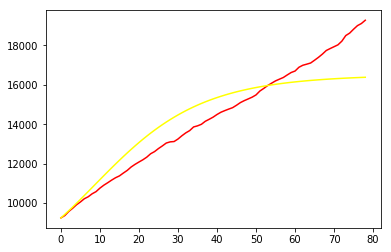

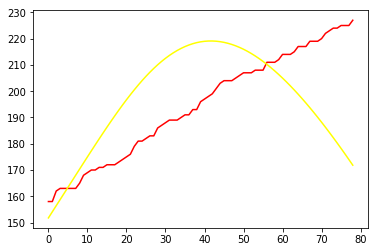

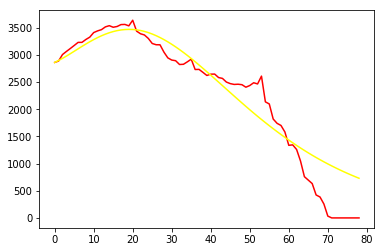

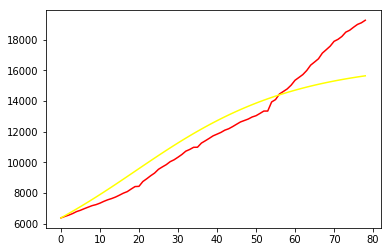

In [16]:
target_state = 'Vermont'
for state, _ in true_state_partial:
    if state != target_state:
        continue
    # split training and validation set
    values = data.loc[state].values
    #training_data = values[:,:]
#    valid_data = values[-7:,:]
    N0_ratio, E0_ratio = best_ratio[state]
    # set y0
    I0 = values[0,4] # Active
    R0 = values[0,2] + values[0,3] # Recovered + Death
    N0 = N0_ratio * state_population.loc[state].values[0]
    E0 = E0_ratio * state_population.loc[state].values[0]
    S0 = N0 - E0 - I0 - R0
    y0 = np.array([S0, E0, I0, R0])
    
    # set initial values for parameters
    #x0 = np.random.rand(4)
    
    # set t_span, t_eval
    t_span = (0, values.shape[0]+1)
    t_eval = np.array(range(values.shape[0])).astype(np.float64)
    res = state_params[state]
    pred = predict_with_ODE(SuEIR, t_span, y0, t_eval = t_eval, 
                           args = (N0, res.x[0], res.x[1], res.x[2], res.x[3]))
    
    date = np.array(range(79))
    
    ratio = state_ratio_by_date[state](torch.FloatTensor(date).view(-1,1))
    ratio = ratio.detach().numpy().squeeze()
    
    death = (pred[3,:] + 1) * ratio
    print(ratio)
    print(death)
    plt.figure()
    plt.plot(date, values[:,1], c='red')
    plt.plot(date, pred[2,:]+pred[3,:], c='yellow')
    plt.figure()
    plt.plot(date, values[:,2], c='red')
    plt.plot(date, death, c='yellow')
    
    plt.figure()
    plt.plot(date, values[:,4], c='red')
    plt.plot(date, pred[2,:], c='yellow')
    
    plt.figure()
    plt.plot(date, values[:,2]+values[:,3], c='red')
    plt.plot(date, pred[3,:], c='yellow')
    
    print(data.loc[state, 'Active'])
print('Finish')

In [15]:
deaths = data.loc['Vermont', 'Deaths'].values[:25]
rcv = data.loc['Vermont', 'Recovered'].values[:25]
ratio = deaths / (deaths+rcv+1)
print(ratio)
print(state_ratio_by_date['Vermont'].linear.weight)
data.loc[data['Active']<0, 'Active'] = 0
print(data.loc['Vermont'])

[0.0247455  0.02438272 0.02467256 0.02443778 0.02398117 0.02368153
 0.02332236 0.02299337 0.02296131 0.02316602 0.02300259 0.02277294
 0.02246597 0.02235879 0.02207591 0.02185792 0.02150269 0.02123719
 0.02092151 0.02064302 0.02072477 0.02009591 0.02002461 0.0198139
 0.01944564]
Parameter containing:
tensor([[ 0.0238, -0.0164]], requires_grad=True)
                      Date  Confirmed  Deaths     Recovered       Active  \
Province_State                                                             
Vermont         01-12-2021       9247     158   6226.000000  2863.000000   
Vermont         01-13-2021       9368     158   6321.000000  2889.000000   
Vermont         01-14-2021       9573     162   6403.000000  3008.000000   
Vermont         01-15-2021       9734     163   6506.000000  3065.000000   
Vermont         01-16-2021       9915     163   6633.000000  3119.000000   
Vermont         01-17-2021      10057     163   6719.000000  3175.000000   
Vermont         01-18-2021      10220    

[79 rows x 14 columns]
